Files already downloaded and verified


/home/yalluri/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yalluri/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50] | Loss D: 1.1589, Loss G: 2.4379, FID: 389.5812
Epoch [2/50] | Loss D: 1.2371, Loss G: 2.2174, FID: 251.2447
Epoch [3/50] | Loss D: 1.3564, Loss G: 3.3826, FID: 316.4984
Epoch [4/50] | Loss D: 0.9543, Loss G: 4.6812, FID: 285.4962
Epoch [5/50] | Loss D: 0.6542, Loss G: 1.5650, FID: 232.4025
Epoch [6/50] | Loss D: 0.8743, Loss G: 1.9890, FID: 241.9610
Epoch [7/50] | Loss D: 1.0939, Loss G: 2.5353, FID: 225.2012
Epoch [8/50] | Loss D: 0.7788, Loss G: 2.8040, FID: 257.9262
Epoch [9/50] | Loss D: 0.6989, Loss G: 1.5557, FID: 268.2023
Epoch [10/50] | Loss D: 0.9016, Loss G: 0.6170, FID: 241.7930
Epoch [11/50] | Loss D: 0.4849, Loss G: 2.4136, FID: 259.7576
Epoch [12/50] | Loss D: 1.0280, Loss G: 2.2115, FID: 283.7565
Epoch [13/50] | Loss D: 0.7694, Loss G: 2.7922, FID: 243.5028
Epoch [14/50] | Loss D: 0.7355, Loss G: 1.0762, FID: 257.8735
Epoch [15/50] | Loss D: 0.7154, Loss G: 6.0692, FID: 215.4444
Epoch [16/50] | Loss D: 0.5848, Loss G: 2.1272, FID: 218.3023
Epoch [17/50] | L

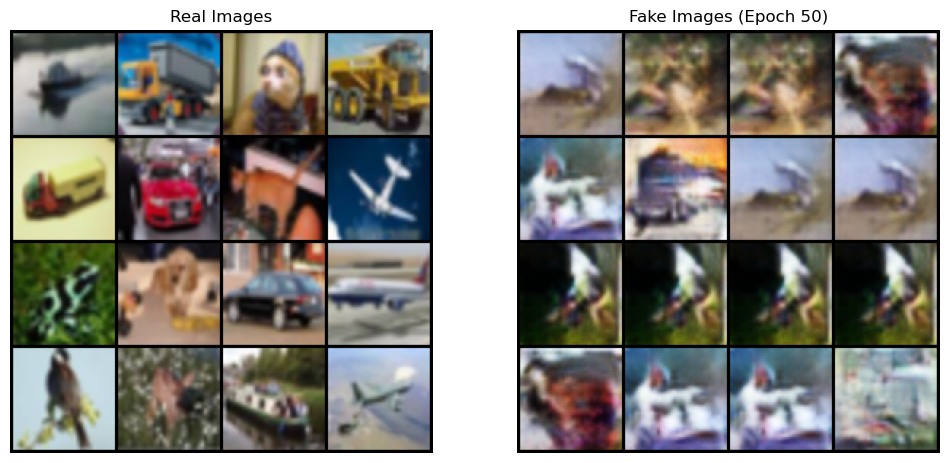

Epoch [50/50] | Loss D: 0.4601, Loss G: 2.8481, FID: 251.6535


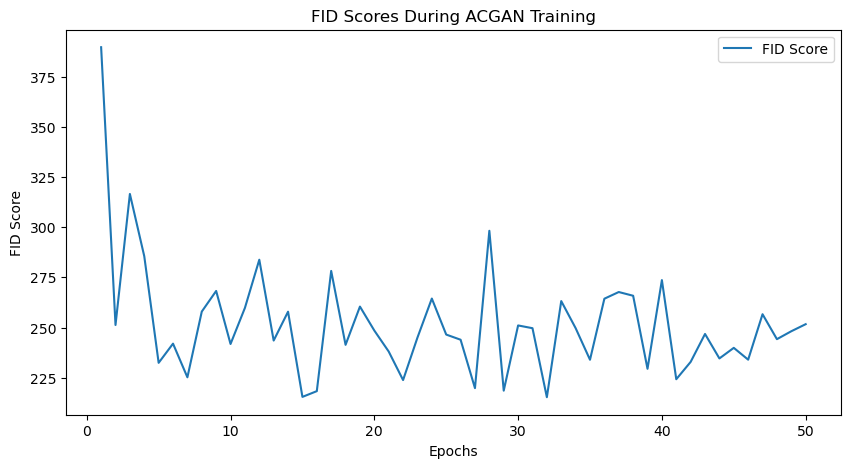

In [2]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from torchvision.models import inception_v3
import numpy as np
from scipy import linalg


transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_path = "./cifar10_data"
dataset = torchvision.datasets.CIFAR10(root=data_path, train=True, transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)


class Generator(nn.Module):
    def __init__(self, noise_dim, num_classes, channels_img, features_g):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_dim + num_classes, features_g * 16, 4, 1, 0, bias=False),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, noise, labels):
        label_emb = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)
        input = torch.cat((noise, label_emb), dim=1)
        return self.model(input)


class Discriminator(nn.Module):
    def __init__(self, num_classes, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1)
        )
        final_dim = features_d * 8 * (64 // 16) ** 2
        self.adv_classifier = nn.Linear(final_dim, 1)
        self.aux_classifier = nn.Linear(final_dim, num_classes)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, img):
        features = self.feature_extractor(img).view(img.size(0), -1)
        validity = torch.sigmoid(self.adv_classifier(features))
        label = self.aux_classifier(features)
        return validity, label


def calculate_fid(real_images, fake_images, inception_model):
    def preprocess_images(images):
        images = (images + 1) / 2
        images = nn.functional.interpolate(images, size=(299, 299), mode="bilinear")
        return images

    def get_activations(images, model):
        images = preprocess_images(images).to(device) 
        with torch.no_grad():
            activations = model(images).view(images.size(0), -1).cpu().numpy()
        return activations

    real_activations = get_activations(real_images, inception_model)
    fake_activations = get_activations(fake_images, inception_model)

    mu_real, sigma_real = np.mean(real_activations, axis=0), np.cov(real_activations, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_activations, axis=0), np.cov(fake_activations, rowvar=False)

    diff = mu_real - mu_fake
    covmean, _ = linalg.sqrtm(sigma_real @ sigma_fake, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = np.sum(diff ** 2) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid


noise_dim = 100
channels_img = 3
num_classes = 10
features_g = 64
features_d = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


gen = Generator(noise_dim, num_classes, channels_img, features_g).to(device)
disc = Discriminator(num_classes, channels_img, features_d).to(device)

optimizer_g = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_d = optim.Adam(disc.parameters(), lr=1e-4, betas=(0.5, 0.999))
adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.CrossEntropyLoss()


fixed_noise = torch.randn(64, noise_dim, 1, 1).to(device)
fixed_labels = torch.randint(0, num_classes, (64,)).to(device)
fid_scores = []


inception_model = inception_v3(pretrained=True, transform_input=False).eval().to(device)
inception_model.fc = nn.Identity()


num_epochs = 50
for epoch in range(1, num_epochs + 1):
    for real_images, real_labels in data_loader:
        real_images, real_labels = real_images.to(device), real_labels.to(device)
        batch_size = real_images.size(0)

     
        noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        fake_images = gen(noise, gen_labels)

        disc_real, aux_real = disc(real_images)
        disc_fake, aux_fake = disc(fake_images.detach())

        real_labels_smooth = torch.ones_like(disc_real) * 0.9
        fake_labels_smooth = torch.zeros_like(disc_fake) + 0.1

        real_loss = adversarial_loss(disc_real, real_labels_smooth) + auxiliary_loss(aux_real, real_labels)
        fake_loss = adversarial_loss(disc_fake, fake_labels_smooth) + auxiliary_loss(aux_fake, gen_labels)
        loss_d = (real_loss + fake_loss) / 2

        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

   
        disc_fake, aux_fake = disc(fake_images)  
        fm_loss = torch.mean((disc_real.detach() - disc_fake) ** 2)  
        loss_g = adversarial_loss(disc_fake, torch.ones_like(disc_fake)) + auxiliary_loss(aux_fake, gen_labels) + 0.1 * fm_loss

        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

   
    with torch.no_grad():
        fake_images_sample = gen(fixed_noise, fixed_labels).detach().cpu()

    fid_score = calculate_fid(real_images[:32], fake_images_sample[:32], inception_model)
    fid_scores.append(fid_score)

    if epoch % 10 == 0:
        torch.save(gen.state_dict(), f"generator_epoch_{epoch}.pth")

    if epoch == num_epochs:
        real_images_sample = real_images[:16].detach().cpu()
        real_grid = make_grid(real_images_sample, normalize=True, nrow=4)
        fake_grid = make_grid(fake_images_sample[:16], normalize=True, nrow=4)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(real_grid.permute(1, 2, 0))
        plt.title("Real Images")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(fake_grid.permute(1, 2, 0))
        plt.title(f"Fake Images (Epoch {epoch})")
        plt.axis("off")
        plt.show()

    print(f"Epoch [{epoch}/{num_epochs}] | Loss D: {loss_d:.4f}, Loss G: {loss_g:.4f}, FID: {fid_score:.4f}")


plt.figure(figsize=(10, 5))
plt.plot(range(1, len(fid_scores) + 1), fid_scores, label="FID Score")
plt.xlabel("Epochs")
plt.ylabel("FID Score")
plt.title("FID Scores During ACGAN Training")
plt.legend()
plt.show()

In [3]:
fid_filename = "./npy_files/acgan_fid_scores.npy"

In [4]:
def save_fid_values(fid_values, filename="./fid_scores.npy"):
    np.save(filename, np.array(fid_values))
    print(f"FID values saved to {filename}.")

In [5]:
save_fid_values(fid_scores, fid_filename)

FID values saved to ./npy_files/acgan_fid_scores.npy.
